# 1.1 Feature Selection

- 1.1.1 Factor Analysis
- 1.1.2 Mutual Information
- 1.1.3 Decision Trees

To visualize decision tree in the notebook, run with:

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
```

In [1]:
%load_ext blackcellmagic

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from research.strings import TARGET, PREDICTORS, INSPECTORS, OTHER_PREDICTORS

In [4]:
data = pd.read_csv("data/train_data.csv")
data[[TARGET] + PREDICTORS].head()

,criticalFound,Inspector_blue,Inspector_brown,Inspector_green,Inspector_orange,Inspector_purple,Inspector_yellow,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage
0,0.0,0,0,1,0,0,0,0.0,0.0,2.0,1,0.0,1.0,53.496667,26.992376,37.748787,12.768572
1,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,59.046667,13.976557,15.412267,12.895485
2,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,59.046667,12.611239,8.320330,8.004220
3,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,56.153333,35.906383,38.186618,26.238645
4,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,52.730000,9.530785,2.126788,3.401567


In [5]:
X = data[PREDICTORS]
y = data[TARGET]
X.shape

(17075, 16)

## 1.1.1 Factor Analysis

In [6]:
from sklearn.decomposition import FactorAnalysis

# Code from: https://stackoverflow.com/questions/41388997/factor-analysis-in-sklearn-explained-variance

def fa_var_explained(fa):
    m = fa.components_
    n = fa.noise_variance_
    m1 = m**2
    m2 = np.sum(m1,axis=1)
    var_explained = m2 / (np.sum(m2) + np.sum(n))
    return var_explained

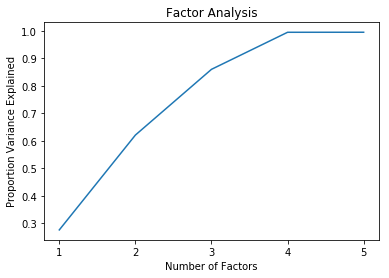

In [7]:
nc_vals = list(range(1, 6))
var_exp = np.zeros(len(nc_vals))
for i, nc in enumerate(nc_vals):
    fa = FactorAnalysis(n_components=nc, random_state=0)
    fa.fit(X)
    var_exp[i] = fa_var_explained(fa).sum()
sns.lineplot(x=nc_vals, y=var_exp)
plt.xticks(nc_vals)
plt.xlabel("Number of Factors")
plt.ylabel("Proportion Variance Explained")
plt.title("Factor Analysis")
plt.show()

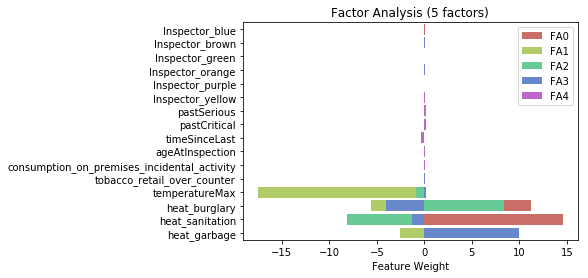

In [8]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0)
fa.fit(X)
colors = sns.color_palette("hls", len(fa.components_))
for i in range(len(fa.components_)):
    sns.barplot(
        x=fa.components_[i], y=PREDICTORS,
        color=colors[i], label="FA{}".format(i)
    )
plt.legend()
plt.xlabel("Feature Weight")
plt.title("Factor Analysis ({} factors)".format(n_factors))
plt.show()

## 1.1.2 Mutual Information

In [9]:
DISCRETE = [
    'Inspector_blue',
    'Inspector_brown',
    'Inspector_green',
    'Inspector_orange',
    'Inspector_purple',
    'Inspector_yellow',
    'pastSerious',
    'pastCritical',
    'consumption_on_premises_incidental_activity',
    'tobacco_retail_over_counter'
]
discrete_idx = [PREDICTORS.index(d) for d in DISCRETE]

In [10]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X, y, discrete_features=discrete_idx, random_state=0)

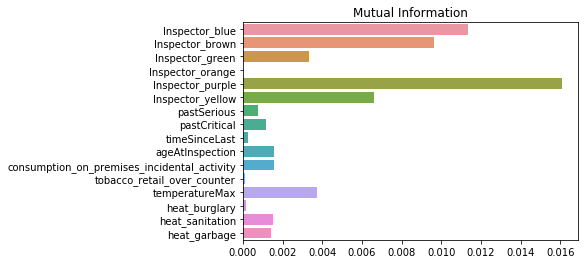

In [11]:
ax = sns.barplot(x=mi, y=PREDICTORS)
plt.title("Mutual Information")
plt.show()

## 1.1.3 Decision Trees

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from research.evaluation import evaluate_model, visualize_tree
import pickle

In [33]:
d_train = pd.read_csv("data/train_data.csv")
d_test = pd.read_csv("data/test_data.csv")
X_train = d_train[PREDICTORS]
X_test = d_test[PREDICTORS]
y_train = d_train[TARGET]
y_test = d_test[TARGET]
print("Train: N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_train), y_train.mean()))
print("Test:  N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_test), y_test.mean()))

Train: N = 17075, P(CriticalFound|X) = 0.141
Test:  N = 1637, P(CriticalFound|X) = 0.158


In [36]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

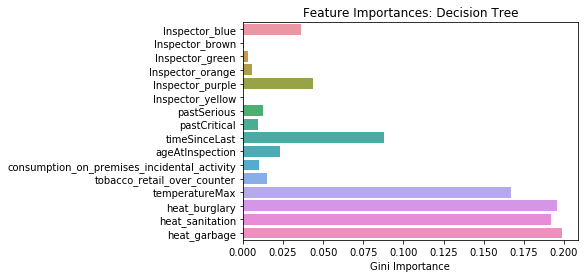

In [38]:
sns.barplot(x=tree.feature_importances_, y=PREDICTORS)
plt.xlabel("Gini Importance")
plt.title("Feature Importances: Decision Tree")
plt.show()

In [39]:
print("Full Decision Tree")
print("------------------")
evaluate_model(y_test, tree.predict(X_test))

Full Decision Tree
------------------
F1 Score = 0.18589
Precision = 0.16718
Recall = 0.20930


,Predicted +,Predicted -
Actual +,54,204
Actual -,269,1110


In [42]:
print("Logistic Regression")
print("------------------")
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, clf.predict(X_test))

Logistic Regression
------------------
F1 Score = 0.08664
Precision = 0.63158
Recall = 0.04651


,Predicted +,Predicted -
Actual +,12,246
Actual -,7,1372


In [43]:
tree_depth = 7
print("Decision Tree (depth = {})".format(tree_depth))
print("------------------")
tree_lim = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)
tree_lim.fit(X_train, y_train)
evaluate_model(y_test, tree_lim.predict(X_test))

Decision Tree (depth = 7)
------------------
F1 Score = 0.11111
Precision = 0.35417
Recall = 0.06589


,Predicted +,Predicted -
Actual +,17,241
Actual -,31,1348


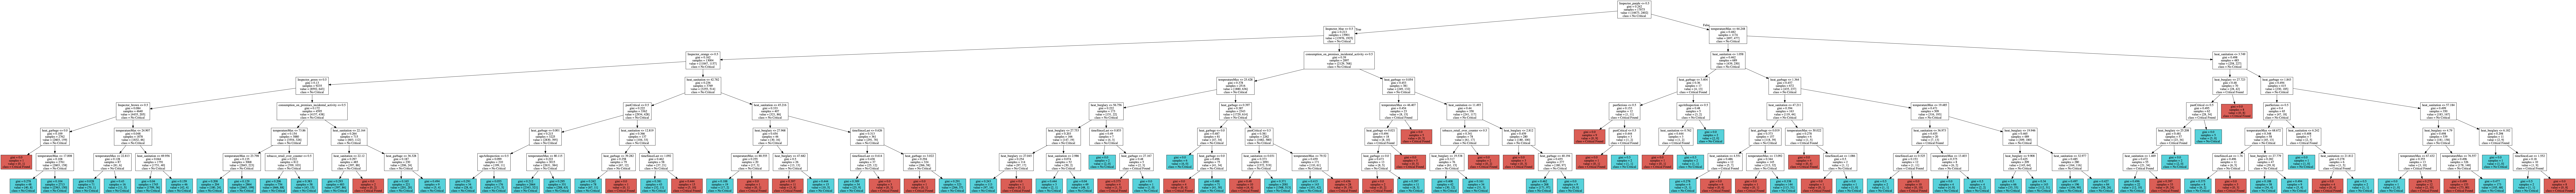

In [45]:
CLASSES = ["No Critical", "Critical Found"]
COLORS = ["#57D2DB", "#DB5E56"]
im = visualize_tree(tree_lim, PREDICTORS, CLASSES, COLORS)
imfile = "figures/tree_height_{}.png".format(tree_depth)
with open(imfile, "wb") as file:
    file.write(im.data)
im